# Определение возраста покупателей

## Исследовательский анализ данных

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим данные:

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
ages = labels['real_age']

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датасете **две колонки** - первая отвечает за **название картинки**, вторая за **возраст человека**, изображенного на ней. В датасете 7591 изображение, **пропусков не обнаружено**

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Описательная статистика** сообщает, что:
1. Средний возраст людей в датасете - 31 год
2. Минимальный возраст - 1 год
3. Максимальный возраст - 100 лет
4. Медиана - 29 лет

Всё логично, **выбросов нет**

Построим **распределение возрастов**:

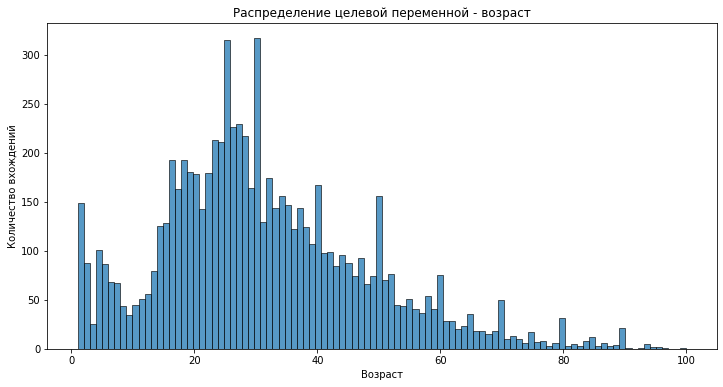

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(ages, bins=100).set(title='Распределение целевой переменной - возраст', 
                       xlabel='Возраст', 
                       ylabel='Количество вхождений');

**Распределение** имеет интересный вид. Мы видим **пик** в районе 30 лет, так как средний возраст по выборке 31 год. Далее заметен длинный **хвост** справа, показывающий что данные "размазаны" по оси и чем далее мы уходим вправо, тем меньше людей такого возраста в нашей выборке. Также имеется пик в районе 0, то есть в нашей выборке много **младенцев и детей**. 

Посмотрим на сами изображения и определим достоверность данных:

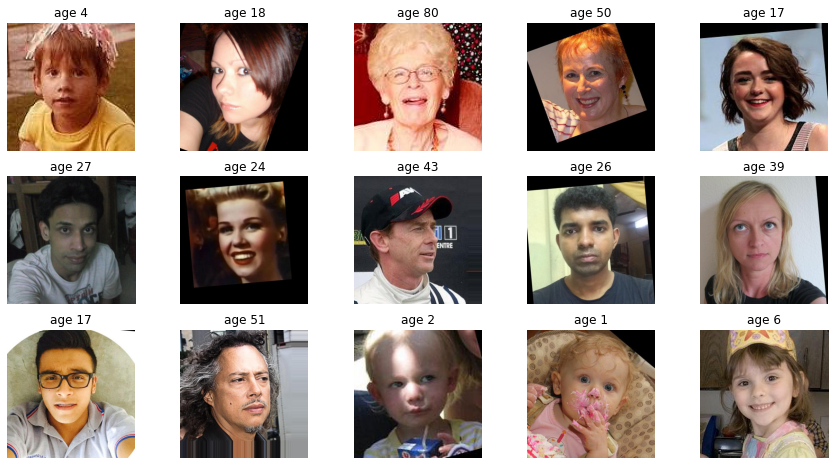

In [7]:
x = 3
y = 5
fig, axs = plt.subplots(3, 5, figsize=(15, 8))
ages_tmp = ages[:15]

for i in range(x):
    for j in range(y):
        if j + i*5 < 10:
            image = Image.open('/datasets/faces/final_files/0000' + '0' + str(j + i*5) + '.jpg')
        else:    
            image = Image.open('/datasets/faces/final_files/0000' + str(j + i*5) + '.jpg')
        array = np.array(image)
        axs[i, j].axis('off')
        axs[i, j].set_title('age' + ' ' + str(ages_tmp[j + i*5]))
        axs[i, j].imshow(array)

На первый взгляд, все возраста соответствуют фотографиям. Также можно заметить, что некоторые фотографии аугментированы: есть повёрнутые фото. В целом фото очень разные, по освещению, по расположению лица на фотографии, также на лицах есть очки, головные уборы.

**Вывод**

Очевидно, что наличие головных уборов, разное освещение, наличие очков на лицах - всё это усложнит процесс обучения, и может ухудшить итоговую метрику. Так как основная масса людей в датасете либо около 30 лет, либо совсем маленькие дети, то на этих фото модель будет получать лучший результат именно на таких фото, а на фото пенсионеров будет работать хуже. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_gen_flow

def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='MSE',
                  metrics=['mean_absolute_error'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
2023-03-30 22:13:31.676209: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-30 22:13:35.221212: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 922.9977 - mean_absolute_error: 25.3602 - val_loss: 783.6717 - val_mean_absolute_error: 23.0931
Epoch 2/7
178/178 - 38s - loss: 279.6387 - mean_absolute_error: 12.7261 - val_loss: 571.9942 - val_mean_absolute_error: 18.9157
Epoch 3/7
178/178 - 38s - loss: 149.2496 - mean_absolute_error: 9.0088 - val_loss: 815.2711 - val_mean_absolute_error: 23.6703
Epoch 4/7
178/178 - 38s - loss: 107.6633 - mean_absolute_error: 7.7012 - val_loss: 211.0805 - val_mean_absolute_error: 10.7746
Epoch 5/7
178/178 - 38s - loss: 85.6921 - mean_absolute_error: 6.9506 - val_loss: 115.3547 - val_mean_absolute_error: 8.1271
Epoch 6/7
178/178 - 38s - loss: 71.9906 - mean_absolute_error: 6.4582 - val_loss: 115.7194 - val_mean_absolute_error: 8.3720
Epoch 7/7
178/178 - 37s - loss: 63.9170 - mean_absolute_error: 6.0024 - val_loss: 84.9684 - val_mean_absolute_error: 6.9676
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 84.9684 - mean_absolute_error: 6.9676
Test MAE: 6.9676
```

## Анализ обученной модели

Итак, обучение производилось на изображениях, которые были аугментированы следующими методами:
1. Горизонтальное отражение

Используемая модель - ResNet50. Learning rate - 0.00001. Использовалась функция потерь MSE для упрощения обучения, а для метрики использовалась MAE. Обучение проходило в 7 эпох.

В конечном итоге удалось достичь значения метрики MAE=6.97, что является приличным результатом. 